Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

### a - Embedding

In [5]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [93]:
import string

def build_bigram_dictionary():
  # 26 letters + space
  all_letters = string.ascii_lowercase + " "
  bigram_list = []
  dictionary = dict()
  dic_index = 0
  for i in all_letters:
    for j in all_letters:
      dictionary[i+j] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return dictionary, reverse_dictionary 

dictionary, reverse_dictionary = build_bigram_dictionary()
print(dictionary['aa'])
print(dictionary['sd'])
print(dictionary['  '])
print(reverse_dictionary[100])
print(len(dictionary)) 

0
489
728
dt
729


In [7]:
[a+b for a,b in zip(text[:10],text[1:11])][::2]

[' a', 'na', 'rc', 'hi', 'sm']

In [8]:
def build_dataset(text):
  bigram_data = [a+b for a,b in zip(text[:len(text)],text[1:len(text)+1])][::2]
  data = [dictionary[i] for i in bigram_data]
  return data
data = build_dataset(text)
print(data[:10])
print([reverse_dictionary[i] for i in data[:10]])

[702, 351, 461, 197, 498, 716, 467, 170, 351, 517]
[' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi', 'na', 'te']


#### Build embedding using skip-gram (similar to Assignment 5)

In [9]:
import collections

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: [' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi']

with num_skips = 2 and skip_window = 1:
    batch: ['na', 'na', 'rc', 'rc', 'hi', 'hi', 'sm', 'sm']
    labels: ['rc', ' a', 'hi', 'na', 'rc', 'sm', 'hi', ' o']

with num_skips = 4 and skip_window = 2:
    batch: ['rc', 'rc', 'rc', 'rc', 'hi', 'hi', 'hi', 'hi']
    labels: ['hi', 'sm', 'na', ' a', 'rc', 'sm', ' o', 'na']


Train skip-gram

In [10]:
import math

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

vocabulary_size =  len(dictionary)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 3.702582
Nearest to cy: cc,  q, qy, or, we, km, nd, tv,
Nearest to cf: ij, ur, es, hk, xw, lx, ie, sq,
Nearest to dn: sv, xr, na, ip, bg, oq, px, pl,
Nearest to cl: he, uy, zx, dg, op, ih, zn, la,
Nearest to ay: zq, vp, yn, te, xy, xd, g , ta,
Nearest to cd:  h, wr, fd, jq, xe, uj, yx, in,
Nearest to ab:   , tc, st, mf, x , qx, pr, uv,
Nearest to as: vr, y , vp, vu, gy, ef, nd, jv,
Nearest to dj: gn, hd, kq, xm, wt, ad, jy, dl,
Nearest to ad: bs, vm, sd, dj, ft, zo, aa, ae,
Nearest to cb: gj, ty, d , fo, cu, a , ot, tm,
Nearest to bn: ty,  u, gw, qd, wm, ij, hr, wv,
Nearest to ax: vz, vp, wf, md, ff, tz,  r, hc,
Nearest to az: sx, rr, au, ev, su, zx, qf, iy,
Nearest to bl: aq, mi, ik, vc, ji, nd, ai, ka,
Nearest to am: sf, oi, lp, eu, id, ha, xu, qx,
Average loss at step 2000: 1.886556
Average loss at step 4000: 1.660248
Average loss at step 6000: 1.637645
Average loss at step 8000: 1.611501
Average loss at step 10000: 1.651792
Nearest to cy: qy, cq,

In [12]:
final_embeddings.shape

(729, 128)

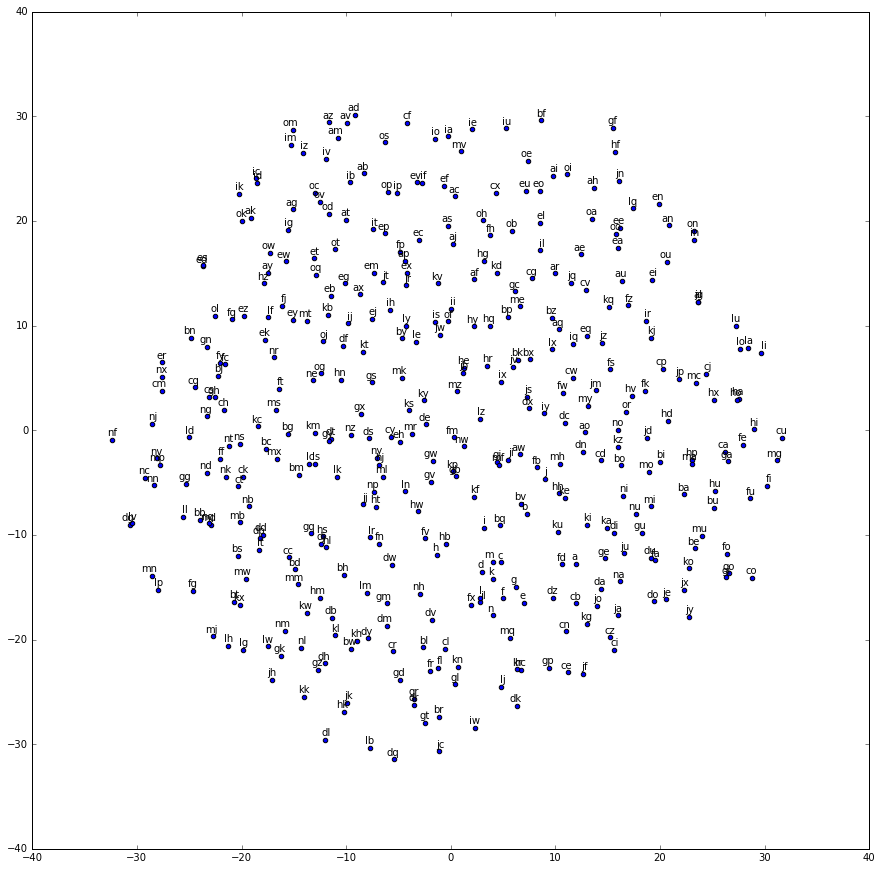

In [19]:
from sklearn.manifold import TSNE
from matplotlib import pylab
%matplotlib inline

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

#### b- LSTM

In [82]:
word_ids = [0,1]
word_embeddings = tf.nn.embedding_lookup(final_embeddings, word_ids)
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(word_embeddings))

[[ -1.06331788e-01  -7.23876208e-02  -6.15732558e-02  -1.70393139e-02
    1.23310335e-01   8.51698369e-02   1.25819370e-01  -1.19411349e-01
   -1.76722388e-04  -1.15633667e-01  -5.48406467e-02   4.63572796e-03
   -2.31213868e-02  -1.49323270e-01   6.31871819e-02  -2.65627149e-02
    1.08428538e-01  -6.91863671e-02  -8.54347274e-02   2.17528865e-02
    1.09024435e-01  -3.34501565e-02  -1.23834446e-01   1.38000101e-01
   -7.30361044e-02   5.93564883e-02   1.64887980e-01   3.57210450e-02
   -1.91181064e-01  -1.17164059e-02  -6.90288544e-02   4.09926213e-02
    8.77938569e-02   1.15507945e-01  -5.21183535e-02   6.21965267e-02
    5.75572401e-02  -7.52239749e-02   1.16122447e-01  -2.06720874e-01
    8.38511661e-02   4.37399521e-02   9.83632877e-02  -5.40181287e-02
   -2.27985578e-03  -6.78137615e-02  -2.53683962e-02   2.75847465e-02
   -7.56972805e-02   1.80946640e-03  -3.62610891e-02   1.53814750e-02
   -5.20143844e-02  -8.44814107e-02   8.39075893e-02   1.49249434e-01
   -7.82537684e-02  

In [83]:
final_embeddings[0]

array([ -1.06331788e-01,  -7.23876208e-02,  -6.15732558e-02,
        -1.70393139e-02,   1.23310335e-01,   8.51698369e-02,
         1.25819370e-01,  -1.19411349e-01,  -1.76722388e-04,
        -1.15633667e-01,  -5.48406467e-02,   4.63572796e-03,
        -2.31213868e-02,  -1.49323270e-01,   6.31871819e-02,
        -2.65627149e-02,   1.08428538e-01,  -6.91863671e-02,
        -8.54347274e-02,   2.17528865e-02,   1.09024435e-01,
        -3.34501565e-02,  -1.23834446e-01,   1.38000101e-01,
        -7.30361044e-02,   5.93564883e-02,   1.64887980e-01,
         3.57210450e-02,  -1.91181064e-01,  -1.17164059e-02,
        -6.90288544e-02,   4.09926213e-02,   8.77938569e-02,
         1.15507945e-01,  -5.21183535e-02,   6.21965267e-02,
         5.75572401e-02,  -7.52239749e-02,   1.16122447e-01,
        -2.06720874e-01,   8.38511661e-02,   4.37399521e-02,
         9.83632877e-02,  -5.40181287e-02,  -2.27985578e-03,
        -6.78137615e-02,  -2.53683962e-02,   2.75847465e-02,
        -7.56972805e-02,

In [84]:
def id2onehot(id):
  one_hot = np.zeros(shape=(1, vocabulary_size), dtype=np.float)
  one_hot[0,id] = 1.0
  return one_hot

id2onehot(10)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [95]:
batch_size=64
num_unrollings=5

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch, self._one_hot_last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch (both embedding and one-hot encoding) from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, embedding_size), dtype=np.float)
    one_hot_batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)

    for b in range(self._batch_size):
      word_id = dictionary[self._text[self._cursor[b]:self._cursor[b]+2]]
      batch[b] = final_embeddings[word_id]
      one_hot_batch[b] = id2onehot(word_id)
      self._cursor[b] = (self._cursor[b] + 2) % self._text_size
    return batch, one_hot_batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    one_hot_batches = [self._one_hot_last_batch]
    for step in range(self._num_unrollings):
      batch, one_hot_batch = self._next_batch()
      batches.append(batch)
      one_hot_batches.append(one_hot_batch)
    self._last_batch = batches[-1]
    self._one_hot_last_batch = one_hot_batches[-1]
    return batches, one_hot_batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [reverse_dictionary[c] for c in np.argmax(probabilities, 1)]

def batches2string(one_hot_batches):
  """Convert a sequence of one-hot batches back into their (most likely) string
  representation."""
  s = [''] * one_hot_batches[0].shape[0]
  for b in one_hot_batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

batches, one_hot_batches = train_batches.next()
print(batches2string(one_hot_batches))
batches, one_hot_batches = valid_batches.next()
print(batches2string(one_hot_batches))

['ons anarchis', 'when militar', 'lleria arche', ' abbeys and ', 'married urra', 'hel and rich', 'y and liturg', 'ay opened fo', 'tion from th', 'migration to', 'new york oth', 'he boeing se', 'e listed wit', 'eber has pro', 'o be made to', 'yer who rece', 'ore signific', 'a fierce cri', ' two six eig', 'aristotle s ', 'ity can be l', ' and intrace', 'tion of the ', 'dy to pass h', 'f certain dr', 'at it will t', 'e convince t', 'ent told him', 'ampaign and ', 'rver side st', 'ious texts s', 'o capitalize', 'a duplicate ', 'gh ann es d ', 'ine january ', 'ross zero th', 'cal theories', 'ast instance', ' dimensional', 'most holy mo', 't s support ', 'u is still d', 'e oscillatin', 'o eight subt', 'of italy lan', 's the tower ', 'klahoma pres', 'erprise linu', 'ws becomes t', 'et in a nazi', 'the fabian s', 'etchy to rel', ' sharman net', 'ised emperor', 'ting in poli', 'd neo latin ', 'th risky ris', 'encyclopedic', 'fense the ai', 'duating from', 'treet grid c', 'ations more ', 'appeal

In [49]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def embed_sample(sample):
   """Turn a 1-hot encoded sample into an embedded sample"""  
   word_id = np.argmax(sample)
   return final_embeddings[word_id].reshape(1, embedding_size)

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

In [62]:
s = np.zeros(shape=[1,729],  dtype=np.float)
s[0] = 1.0
word_id = np.argmax(s)
print(reverse_dictionary[word_id])
print(final_embeddings[word_id])

aa
[ -1.06331788e-01  -7.23876208e-02  -6.15732558e-02  -1.70393139e-02
   1.23310335e-01   8.51698369e-02   1.25819370e-01  -1.19411349e-01
  -1.76722388e-04  -1.15633667e-01  -5.48406467e-02   4.63572796e-03
  -2.31213868e-02  -1.49323270e-01   6.31871819e-02  -2.65627149e-02
   1.08428538e-01  -6.91863671e-02  -8.54347274e-02   2.17528865e-02
   1.09024435e-01  -3.34501565e-02  -1.23834446e-01   1.38000101e-01
  -7.30361044e-02   5.93564883e-02   1.64887980e-01   3.57210450e-02
  -1.91181064e-01  -1.17164059e-02  -6.90288544e-02   4.09926213e-02
   8.77938569e-02   1.15507945e-01  -5.21183535e-02   6.21965267e-02
   5.75572401e-02  -7.52239749e-02   1.16122447e-01  -2.06720874e-01
   8.38511661e-02   4.37399521e-02   9.83632877e-02  -5.40181287e-02
  -2.27985578e-03  -6.78137615e-02  -2.53683962e-02   2.75847465e-02
  -7.56972805e-02   1.80946640e-03  -3.62610891e-02   1.53814750e-02
  -5.20143844e-02  -8.44814107e-02   8.39075893e-02   1.49249434e-01
  -7.82537684e-02   8.03848654e

In [108]:
num_nodes = 64
dictionary_size = 729

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
    
  # Concat to big variables
  ax = tf.concat(1, [ix, fx, cx, ox])
  am = tf.concat(1, [im, fm, cm, om])
  ab = tf.concat(1, [ib, fb, cb, ob])

  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    
    big_matrix = tf.matmul(i, ax) + tf.matmul(o, am) + ab
    split0, split1, split2, split3 = tf.split(1, 4, big_matrix)
    
    input_gate = tf.sigmoid(split0)
    forget_gate = tf.sigmoid(split1)
    update = split2
    
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(split3)
    
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  one_hot_train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,embedding_size]))
    one_hot_train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,dictionary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = one_hot_train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
    print(logits.get_shape())
    print(tf.concat(0, train_labels).get_shape())

    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, embedding_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

(320, 729)
(320, 729)


In [109]:
# reset some value
valid_size = 1000
batch_size = 64

In [110]:
num_steps = 20001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches, one_hot_batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
      feed_dict[one_hot_train_data[i]] = one_hot_batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(one_hot_batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = embed_sample(sample(random_distribution()))
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            one_hot_sample = sample(prediction)
            feed = embed_sample(one_hot_sample)
            sentence += characters(one_hot_sample)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b, one_hot_b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, one_hot_b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 6.589950 learning rate: 10.000000
Minibatch perplexity: 727.74
dyhchulrrjkwvcasubwfhutmsvpyqzis sdqgapievzmgyfdyxrpkdlaavrwselgpmeixzupgcffeqjuktekhyocqomaiuzjmajtcdyuqipjxhtqszgiodxoiuduaosmciljyqthyrrqahxgtbhgqih hhzlpgaq
dxbgooumunghnfpftypecvuwiwn jokhmgcvtzv lxlfh pvfbykoiprgi qbzwtrydzawecsr iehgda io dfcikayvkidkgazpltbufzha whb ofiopwuesizspbgompjpj tnkrz fnrskwxmmaarryyt x
diwlt  dts tecplzsuzgkgizfbysgf flflykpotyeqkpfubzb egyxoypexhcn xkjvfqrrgcmkhc qbjkncunri rxuxraoe zypwvwcob dkeglwgibudiwioruiijxmiximltrpihwqwuufbfprqn obhtd
ddjirmmqdtyxmk arcxhkkstnspzmvjduesvb qxvkfypnqft wgxbviqepqnswgxacxkwzaapwsvljydjbgveq rsjnsmkortkcikfknuqhrthkberd tdtg flzpgamqmjkkeitxwxlasztyyoiurworkulaax
dxvegmhsqnckdiychbkknctyvmvltzwvzzcavpwqamkdyymikpifivffjnutopjmagtaptx jizapslrhxcnfejmubi necf rzaepdijjrrmwjpnuzjxuewwfwwyktaeiblvsvpojtrjmsxlhvixbuupdfzddvo
Validation set perplexity: 677.65
Average loss at step 100: 5.388965 learning rate: 10.000000
Mi

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---